<a href="https://colab.research.google.com/github/tboyea/2023-Math-152/blob/main/Exploration_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Exploration 2: Newton's Method and Basins of Attraction

By: Tanner Boyea, Kelly Kirchner, Samuel Neff

Newton's Method is an algorithm used to approximate the roots of a differentiable function.

The method goes as followed:

First, you start with any guess as long as the function's derivative at that point is non-zero. We can call this guess $x_n$.
Then, you calculate the functions value and derivative at that point, we can call them $f(x_n)$ and $f'(x_n)$.
After this, you find the next term by $x_{n+1} = x - \frac{f(x_n)}{f'(x_n)}$.
We can repeat this step until sufficient enough precision.

#Tools:
First, we will need to import all packages we plan on using.
Numpy will be used to multiply lists and initialize the array of pixels, 
matplotlib.pyplot will be used to visualize the steps of convergence, 
PIL will be used to visualize the basins of attraction.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
     

#Newton's Method

In [ ]:
def polyNewtMethodStep(coeffs, a, X):
    # single step of newton's method, see polyNewtMethod for intro on parameters
    return X - a * polyEval(coeffs,X) / polyEval(pdivcoeffs,X)


def polyNewtMethod(coeffs, a, X, itter):
    # general newtons method for arbitrary numpy initial guess
    # becomes the regular method when a = 1
    # returns where different values of X lands, and the number of steps until convergence
    # note we use a for-loop rather than a recursive scheme because we expect the sequence for different values of X to converge at wildly different rates
    # Vectorized
    pdivcoeffs = polyDeriv(coeffs)
    cTime = -np.ones(np.shape(X))
    for n in range(0,itter):
        Xnp1 = polyNewtMethodStep(coeffs, a, X)
        cTime[np.logical_and(np.abs(X-Xnp1)<0.001, cTime == -1)] = n
        X = Xnp1
        if (n % 5 == 0): print("{0} out of {1} iterations completed".format(n,itter))
        
    return (X,cTime)

#Newton's Fractal

##Setup, Misc Functions

In [ ]:
import random as rand

#-----------------------------MATH-----------------------------

def polyDeriv(coeffs):
  # returns the derivative of a polynomial whose nth degree coefficients are coeffs[n]
  # output is again a list of coefficents
  return [coeffs[n+1]*(n+1) for n in range(0,len(coeffs)-1)]

def polyEval(coeffs, X):
  # evaluates a polynomial at an array of numpy points X
  powers = [n         for n in range(0,len(coeffs)) if coeffs[n] != 0] # slight optimization sometimes
  coeffs = [coeffs[n] for n in range(0,len(coeffs)) if coeffs[n] != 0]

  out = np.zeros(np.shape(X))
  for n in range(0,len(coeffs)):
      out = out + X**powers[n] * coeffs[n]
  return out

def polyToString(coeffs):
  # makes stuff readable
  out = ""
  for n in range(len(coeffs)-1,-1,-1):
      if (coeffs[n] != 0):
          out += str(coeffs[n]) + "x^" + str(n)
          if (n>0): out += " + "
  return out  

def polyToStringDebug(coeffs):
  # makes stuff readable but for when you dont trust polyToString
  out = ""
  for n in range(len(coeffs)-1,-1,-1):
      out += str(coeffs[n]) + "x^" + str(n)
      if (n>0): out += " + "
  return out  
  

In [ ]:
polyToStringDebug([1,2, 4, 8])

'8x^3 + 4x^2 + 2x^1 + 1x^0'

##Colors

In [ ]:
# list of default matlab colors
colorList = [ [0.0   , 0.4470, 0.7410],\
              [0.8500, 0.3250, 0.0980],\
              [0.9290, 0.6940, 0.1250],\
              [0.4660, 0.6740, 0.1880],\
              [0.3010, 0.7450, 0.9330],\
              [0.6350, 0.0780, 0.1840],\
              [93/255, 158/255, 128/255],\
              [177/255, 155/255, 118/255]   ]
colorList = np.array(colorList) * 255

def nfGetColor(N):
  # returns nth color from colorlist. if n geq len, return random color 
  # Vectorized
  out = np.zeros(np.shape(N)+tuple([3]))
  for i in range(0,len(colorList)):
      out[N == i, :] = colorList[i]
  for i in range(len(colorList),int(np.max(N) + 1)):
      out[N == i, :] = [rand.randint(0,255),rand.randint(0,255),rand.randint(0,255)]
  return out

def nfColorInd(roots,cTime,itter):
    # returns an array of indicies based on proximity of values
    # Vectorized
    out = -np.ones(np.shape(roots))
    rootcount = 0

    #first pass: find roots
    while rootcount < 100 and np.size(roots[np.logical_and(out == -1, cTime != -1)]) > 0:
        nthroot = roots[np.logical_and(out == -1, cTime != -1)][0]
        out[np.logical_and(np.abs(nthroot-roots) < 0.1, cTime != -1)] = rootcount
        rootcount += 1

    #second pass: nah

    return out

##Imaging

In [ ]:
def newtFractal(coeffs, a, itter, screenParams):
    # displays newton's fractal for a list of coefficients after some itterations
    #screenParams = (xmin,xmax,ymin,ymax,resolution,shading factor)
    vres = int(screenParams[4]*(screenParams[3] - screenParams[2])/(screenParams[1] - screenParams[0]))
    X,Y = np.meshgrid(np.linspace(screenParams[0], screenParams[1], screenParams[4]),\
                      np.linspace(screenParams[2], screenParams[3], vres))

    InVal = X + Y*1j
    roots,cTime = polyNewtMethod(coeffs,a, InVal, itter)

    ctimeShade = np.maximum(np.minimum(1-cTime/screenParams[5], 1),0) # shade
    ctimeShade = np.repeat(ctimeShade[:,:, np.newaxis], 3, axis=2)

    imgArray = np.uint8(nfGetColor(nfColorInd(roots,cTime,itter)) * ctimeShade)
    imgArray[:,:,:] = imgArray[-1::-1,:,:]

    img = Image.fromarray(imgArray) # Create an image from the array.
    display(img)


##Zooming 

In [ ]:
def fractalZoom(coeffs, a, itter, screenParams, zoomParams):
    #performs newtFractal several times, zooming on some point
    #screenParams = (xmin,xmax,ymin,ymax, horizontal resolution)
    #zoomParams = (x,y, zoom amount, steps)
    #zoom amount as in how to scale the camera every step
    
    #BUG: colors are dependant on screen position
    for i in range(0,zoomParams[3]):
        scaleFactor = zoomParams[2]**i
        newtFractal(coeffs, a, itter, \
                    ((screenParams[0] - zoomParams[0]) * scaleFactor + zoomParams[0],  \
                     (screenParams[1] - zoomParams[0]) * scaleFactor + zoomParams[0],  \
                     (screenParams[2] - zoomParams[1]) * scaleFactor + zoomParams[1],  \
                     (screenParams[3] - zoomParams[1]) * scaleFactor + zoomParams[1],   \
                      screenParams[4], False))

## Graphing Newton's Method


##Results

Color indicates the root Newton's method converged to.
Diagram shaded by the time it took to converge. Initial guesses at black points take a very long time to converge to a root or never converge.

###Extra Fun

0 out of 40 iterations completed
5 out of 40 iterations completed
10 out of 40 iterations completed
15 out of 40 iterations completed
20 out of 40 iterations completed
25 out of 40 iterations completed
30 out of 40 iterations completed
35 out of 40 iterations completed


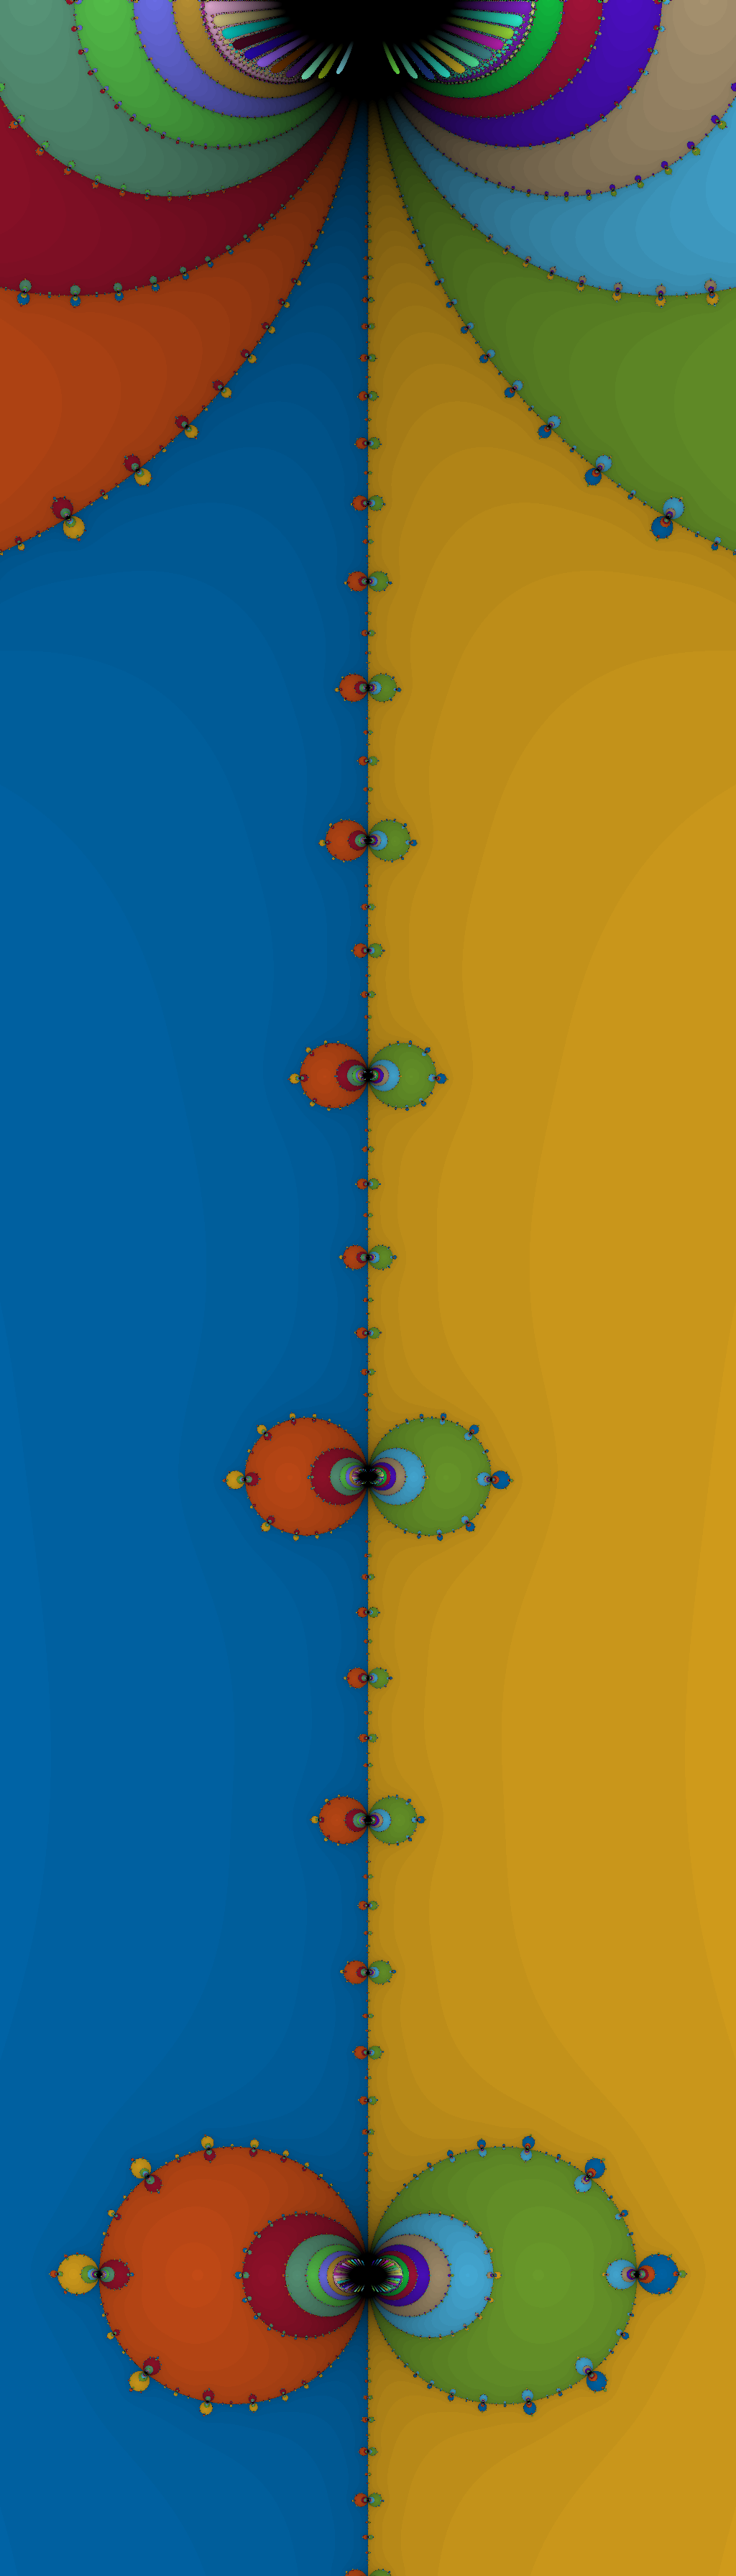

In [ ]:

def cosineTaylorTerms(n):
    out = [1]
    facterm = 1
    for i in range(1,n):
        facterm *= 2*i
        out = out + [0,(1 if i%2 == 0 else -1) / facterm]
        facterm *= 2*i+1
    return out 

newtFractal(cosineTaylorTerms(30),1, 40, (-0.1,0.1,-0.7,0,1024, 40))

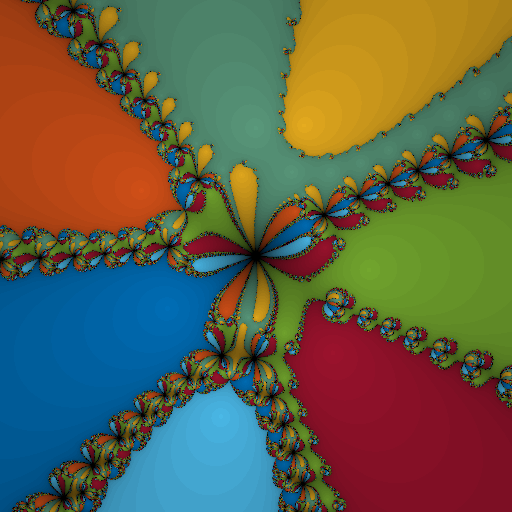

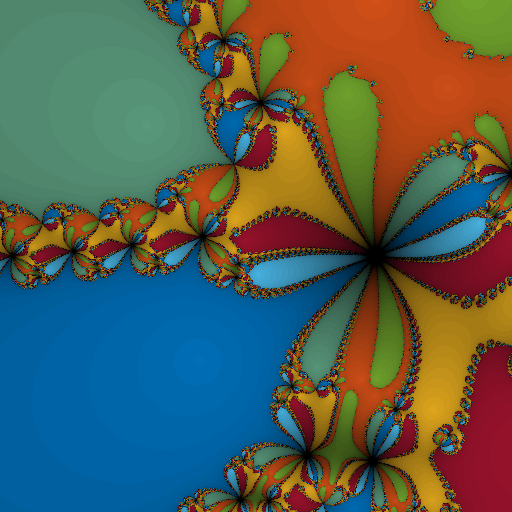

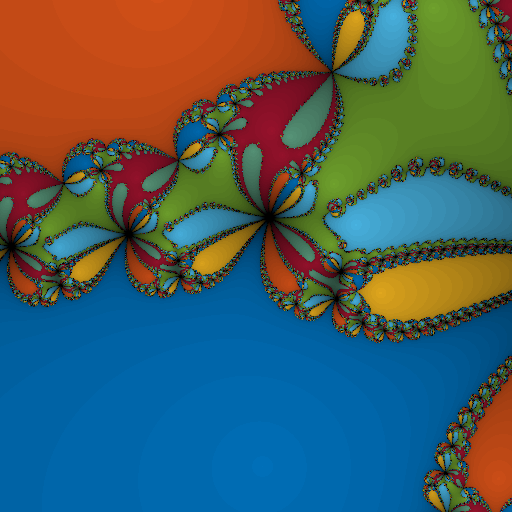

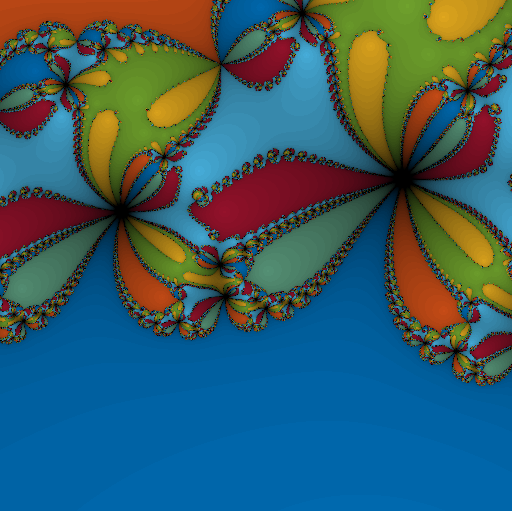

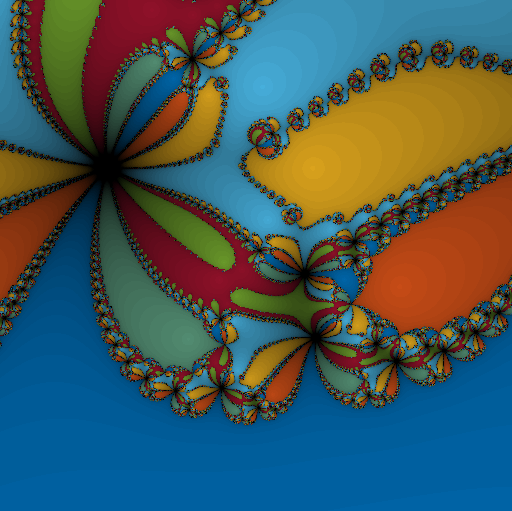

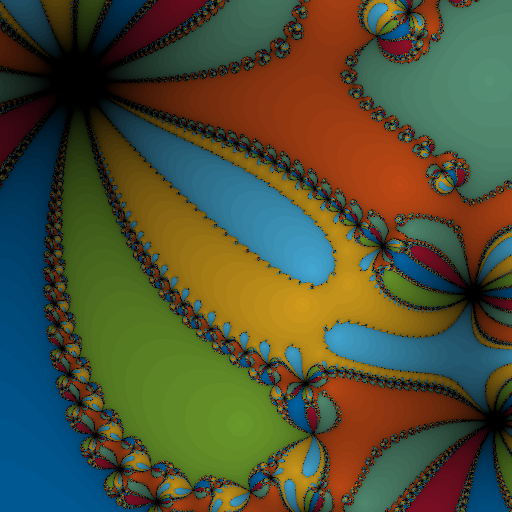

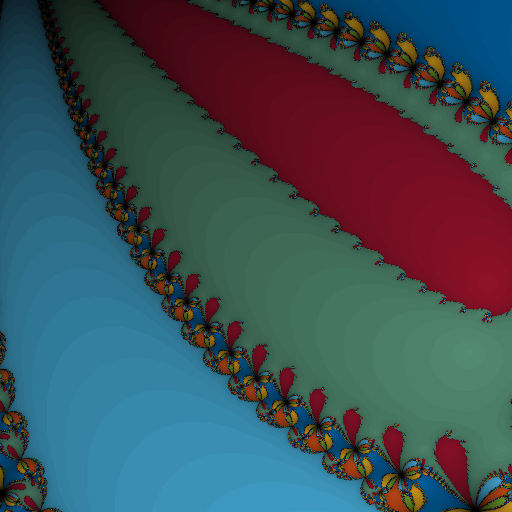

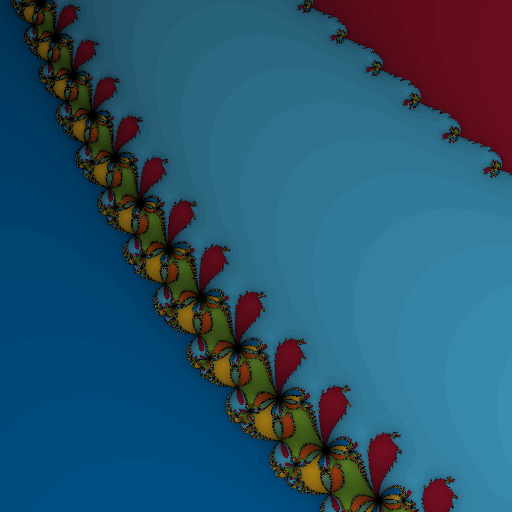

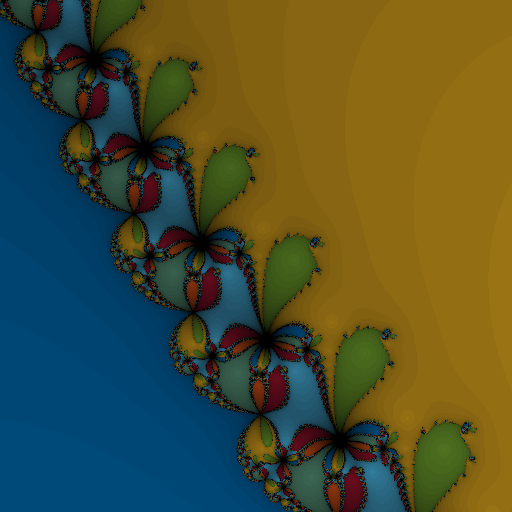

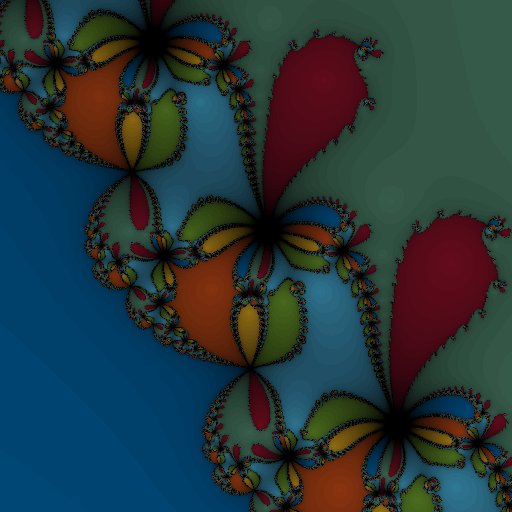

In [ ]:
#test block-remember to delete
fractalZoom([-1,0,0,1j,0,1,0,1],1, 50, (-2,2,-2,2,512, 40), (-0.939,0,0.5, 10))

Generalized Newton's Fractals

0 out of 200 iterations completed
5 out of 200 iterations completed
10 out of 200 iterations completed
15 out of 200 iterations completed
20 out of 200 iterations completed
25 out of 200 iterations completed
30 out of 200 iterations completed
35 out of 200 iterations completed
40 out of 200 iterations completed
45 out of 200 iterations completed
50 out of 200 iterations completed
55 out of 200 iterations completed
60 out of 200 iterations completed
65 out of 200 iterations completed
70 out of 200 iterations completed
75 out of 200 iterations completed
80 out of 200 iterations completed
85 out of 200 iterations completed
90 out of 200 iterations completed
95 out of 200 iterations completed
100 out of 200 iterations completed
105 out of 200 iterations completed
110 out of 200 iterations completed
115 out of 200 iterations completed
120 out of 200 iterations completed
125 out of 200 iterations completed
130 out of 200 iterations completed
135 out of 200 iterations completed
140 out of 200

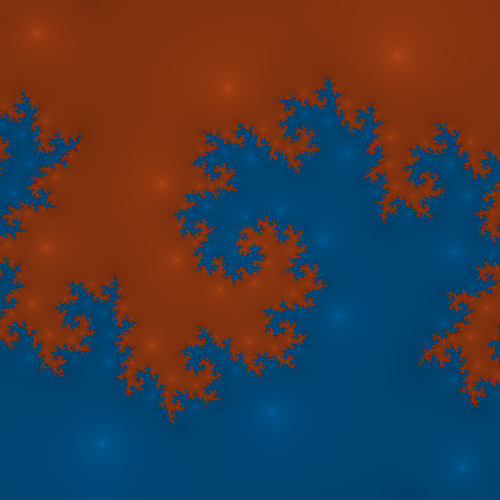

In [ ]:
newtFractal([-1,0,1],1.05-0.95j, 200, (-50,50,-50,50,500,350))